### Importing the Libraries

In [97]:
# Load essential libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import glob,string
import codecs
from tqdm import tqdm
from PIL import Image

from torchinfo import summary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.exposure import histogram as sk_hist



In [98]:
def contructDataframe(file_list):
    """
    this function builds a data frame which contains 
    the path to image and the tag/object name using the prefix of the image name
    """
    data=[]
    for file in tqdm(file_list):
        prefix = file.split("/")[-1].split("__")[0]
        label = int(prefix.lstrip(string.ascii_letters)) -1 # for zero-based for pytorch crossentropy
        data.append((file,label,prefix))
    return pd.DataFrame(data,columns=['path','label','class'])


In [99]:
class CreateDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df = dataframe.reset_index(drop=True)
        self.paths = df["path"].tolist()
        self.targets = df["label"].astype(int).tolist()
        self.transform = transform

        label_to_class = dict(zip(df["label"], df["class"]))
        self.classes = [label_to_class[i] for i in sorted(label_to_class.keys())]
        self.class_to_idx = {name: i for i, name in enumerate(self.classes)}

    def __len__(self): 
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(self.targets[idx], dtype=torch.long)

In [ ]:
def feature_extraction1(pil, bins=32, edge_thresh=0.2):
    g = rgb2gray(np.asarray(pil.convert("RGB")))    

    hist, _ = sk_hist(g, nbins=bins, source_range='dtype', normalize=True)
    hist = hist.astype(np.float32)

    mag = sobel(g).astype(np.float32)
    mean_mag = np.float32(mag.mean())
    edge_density = np.float32((mag > edge_thresh).mean())


    return torch.from_numpy(np.concatenate([hist, [mean_mag, edge_density]])).float()


In [137]:
from skimage.color import rgb2gray, rgb2hsv
from skimage.exposure import histogram as sk_hist
from skimage.filters import sobel

def feature_extraction(pil, bins=32, hsv_bins=16, edge_thresh=0.2):

    rgb = np.asarray(pil.convert("RGB"))
    g   = rgb2gray(rgb)

    # Grå-hist
    hist_g, _ = sk_hist(g, nbins=bins, source_range='dtype', normalize=True)
    hist_g = hist_g.astype(np.float32)

    # HSV-hist per kanal
    hsv = rgb2hsv(rgb)
    H,_ = sk_hist(hsv[...,0], nbins=hsv_bins, source_range='dtype', normalize=True)
    S,_ = sk_hist(hsv[...,1], nbins=hsv_bins, source_range='dtype', normalize=True)
    V,_ = sk_hist(hsv[...,2], nbins=hsv_bins, source_range='dtype', normalize=True)
    H = H.astype(np.float32); S = S.astype(np.float32); V = V.astype(np.float32)

    # Sobel på gråskala (struktur)
    mag = sobel(g).astype(np.float32)
    mean_mag     = np.float32(mag.mean())
    edge_density = np.float32((mag > edge_thresh).mean())

    feat = np.concatenate([hist_g, H, S, V, [mean_mag, edge_density]]).astype(np.float32)
    return torch.from_numpy(feat)


### Loading the Dataset Coil-100 dataset

In [174]:
def get_coil100_train_valid_loader(batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    
    path = 'coil-100/*.png'
    files=glob.glob(path)
    

    transform = transforms.Compose([
        #transforms.Resize((64, 64)),
        #transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda pil: feature_extraction(pil, bins=32, edge_thresh=0.2)),
    ])

    dataset = CreateDataset(contructDataframe(files), transform=transform)
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   
    train_size = int(percent_train * dataset_size)   # 80%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  # rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader, classes



### Loading the Dataset EuroSAT dataset

In [175]:
def get_EuroSAT_train_valid_loader(data_dir, batch_size, percent_train=0.8, shuffle=True, random_seed=42):

    transform = transforms.Compose([
       # transforms.Resize((64, 64)),
        #transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda pil: feature_extraction(pil, bins=32, edge_thresh=0.2)),
        
    ])

    # load the dataset
    dataset = datasets.EuroSAT(root=data_dir, download=True, transform=transform,)
    print(type(dataset))
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   # ~27,000 images
    train_size = int(percent_train * dataset_size)   # 80%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  #  rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return (train_loader, valid_loader, test_loader, classes)


### Train and validate

In [162]:
def train(model, train_loader, valid_loader, num_epochs=10):
  train_losses, valid_losses = [], []


  for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    total_samples = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_size = labels.size(0)
      running_loss += loss.item() * batch_size
      total_samples += batch_size

    epoch_train_loss = running_loss / total_samples if total_samples > 0 else 0.0
    train_losses.append(epoch_train_loss)

    # Validation after each epoch
    val_loss, val_acc = evaluate(model, valid_loader)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

  plot_loss(train_losses, valid_losses)
  return train_losses, valid_losses

### Test your model

In [163]:
def plot_loss(train_losses, val_losses):
    """
    Plot training and validation loss over epochs.

    Args:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [170]:
# --- Evaluation ---
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = 100.0 * total_correct / total_samples if total_samples > 0 else 0.0
    model.train()
    return avg_loss, accuracy


In [149]:
# just for checking if GPU is available MAC M1/M2 or CUDA GPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)


mps


# Chose a Dataset and load it to be used to train the ANN model

In [176]:
# load EuroSAT dataset
train_loader, valid_loader, test_loader, classes = get_EuroSAT_train_valid_loader(data_dir = './data',batch_size = 128, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

print(images.shape)

<class 'torchvision.datasets.eurosat.EuroSAT'>
torch.Size([128, 82])


In [139]:
# load Coil-100 dataset
train_loader, valid_loader, test_loader, classes = get_coil100_train_valid_loader(batch_size = 128, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

print(images.shape)


100%|██████████| 7200/7200 [00:00<00:00, 556673.65it/s]


torch.Size([128, 82])


In [171]:
class BaseANN(nn.Module):
    def __init__(self, in_features: int, num_classes: int, p: float = 0.3):
        super().__init__()
        self.norm = nn.LayerNorm(in_features)
        self.lin1 = nn.Linear(in_features=in_features, out_features=128)
        self.drop1 = nn.Dropout(p)
        self.lin2 = nn.Linear(in_features=128, out_features=64)
        self.drop2 = nn.Dropout(p)
        self.lin3 = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.norm(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        x = F.relu(self.lin2(x))
        x = self.drop2(x)
        x = self.lin3(x)
        return x

# start the training & evaluation of the model and then final test the model to predict the classes

Epoch 1/20 - Train Loss: 1.5393 - Val Loss: 1.1205 - Val Acc: 60.05%
Epoch 2/20 - Train Loss: 1.1042 - Val Loss: 0.9352 - Val Acc: 65.46%
Epoch 3/20 - Train Loss: 0.9779 - Val Loss: 0.8538 - Val Acc: 69.38%
Epoch 4/20 - Train Loss: 0.9132 - Val Loss: 0.7998 - Val Acc: 71.21%
Epoch 5/20 - Train Loss: 0.8678 - Val Loss: 0.7735 - Val Acc: 72.30%
Epoch 6/20 - Train Loss: 0.8342 - Val Loss: 0.7299 - Val Acc: 73.65%
Epoch 7/20 - Train Loss: 0.8043 - Val Loss: 0.7104 - Val Acc: 74.91%
Epoch 8/20 - Train Loss: 0.7823 - Val Loss: 0.6928 - Val Acc: 75.04%
Epoch 9/20 - Train Loss: 0.7631 - Val Loss: 0.6713 - Val Acc: 75.56%
Epoch 10/20 - Train Loss: 0.7458 - Val Loss: 0.6634 - Val Acc: 75.70%
Epoch 11/20 - Train Loss: 0.7303 - Val Loss: 0.6450 - Val Acc: 76.54%
Epoch 12/20 - Train Loss: 0.7179 - Val Loss: 0.6350 - Val Acc: 77.04%
Epoch 13/20 - Train Loss: 0.7063 - Val Loss: 0.6207 - Val Acc: 77.58%
Epoch 14/20 - Train Loss: 0.6929 - Val Loss: 0.6142 - Val Acc: 77.70%
Epoch 15/20 - Train Loss: 0.6

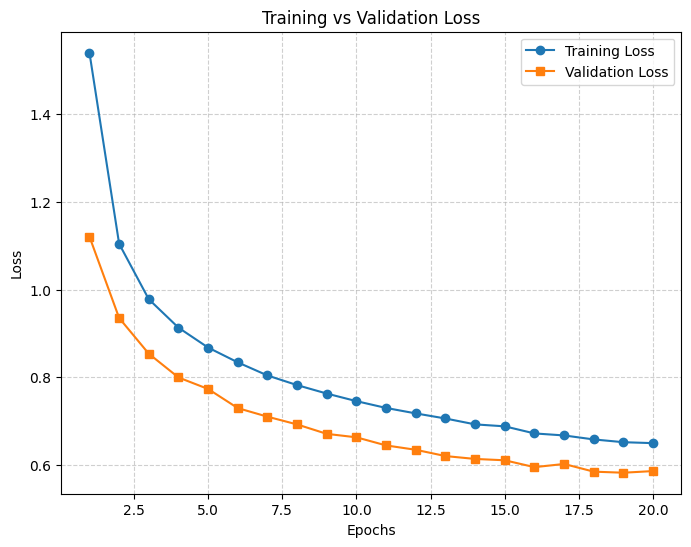

Test Accuracy: 78.89%


In [179]:
xb ,_ = next(iter(train_loader))       
in_dim = xb.shape[1]
num_classes=len(classes)

model = BaseANN(in_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# --- Run training ---
train(model, train_loader, valid_loader, num_epochs=20)

# --- Test accuracy ---
_,test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

In [178]:

summary(model, input_size=(128, in_dim))


Layer (type:depth-idx)                   Output Shape              Param #
BaseANN                                  [128, 10]                 --
├─LayerNorm: 1-1                         [128, 82]                 164
├─Linear: 1-2                            [128, 128]                10,624
├─Dropout: 1-3                           [128, 128]                --
├─Linear: 1-4                            [128, 64]                 8,256
├─Dropout: 1-5                           [128, 64]                 --
├─Linear: 1-6                            [128, 10]                 650
Total params: 19,694
Trainable params: 19,694
Non-trainable params: 0
Total mult-adds (M): 2.52
Input size (MB): 0.04
Forward/backward pass size (MB): 0.29
Params size (MB): 0.08
Estimated Total Size (MB): 0.41